In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings
from lib.merge import prepare_train_show

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable

spark = SparkSession.builder.appName("renovation").getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {
        "location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full",
        "delimiter": ",",
    },
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"},
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi = dataframes["pred_tremi_full"].withColumns(
    {
        "surface": F.col("surface").cast("int"),
        "heating_production": F.col("heating_production").cast("int"),
    }
)

dictionary = dataframes["dictionary"]

In [5]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col("surface").isNotNull()).drop(
    "heating_production"
)
predicting_surf = training_tremi.filter(F.col("surface").isNull()).drop(
    "heating_production"
)

training_prod = training_tremi.filter(F.col("heating_production").isNotNull()).drop(
    "surface"
)
predicting_prod = training_tremi.filter(F.col("heating_production").isNull()).drop(
    "surface"
)

print(
    f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
"""
)


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370




# ML

In [6]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# linear
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# HistGboost
from sklearn.ensemble import HistGradientBoostingClassifier

# hyperparams
from scipy.stats import uniform, randint

## surface

0.6106481481481483 {'C': 6.522117123602399, 'class_weight': 'balanced', 'max_iter': 1000}
0.5540895061728395 {'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 102}
0.6249228395061729 {'l2_regularization': 0.17592525267734538, 'learning_rate': 0.03542260908465626, 'max_iter': 241}
not handled for this type of algorithm


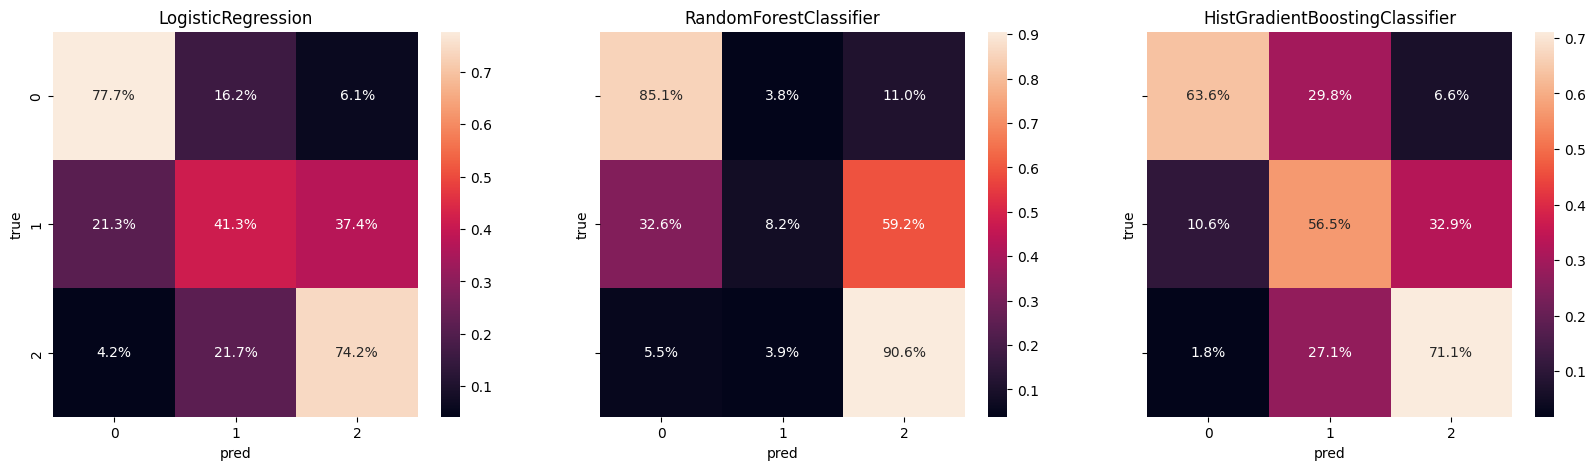

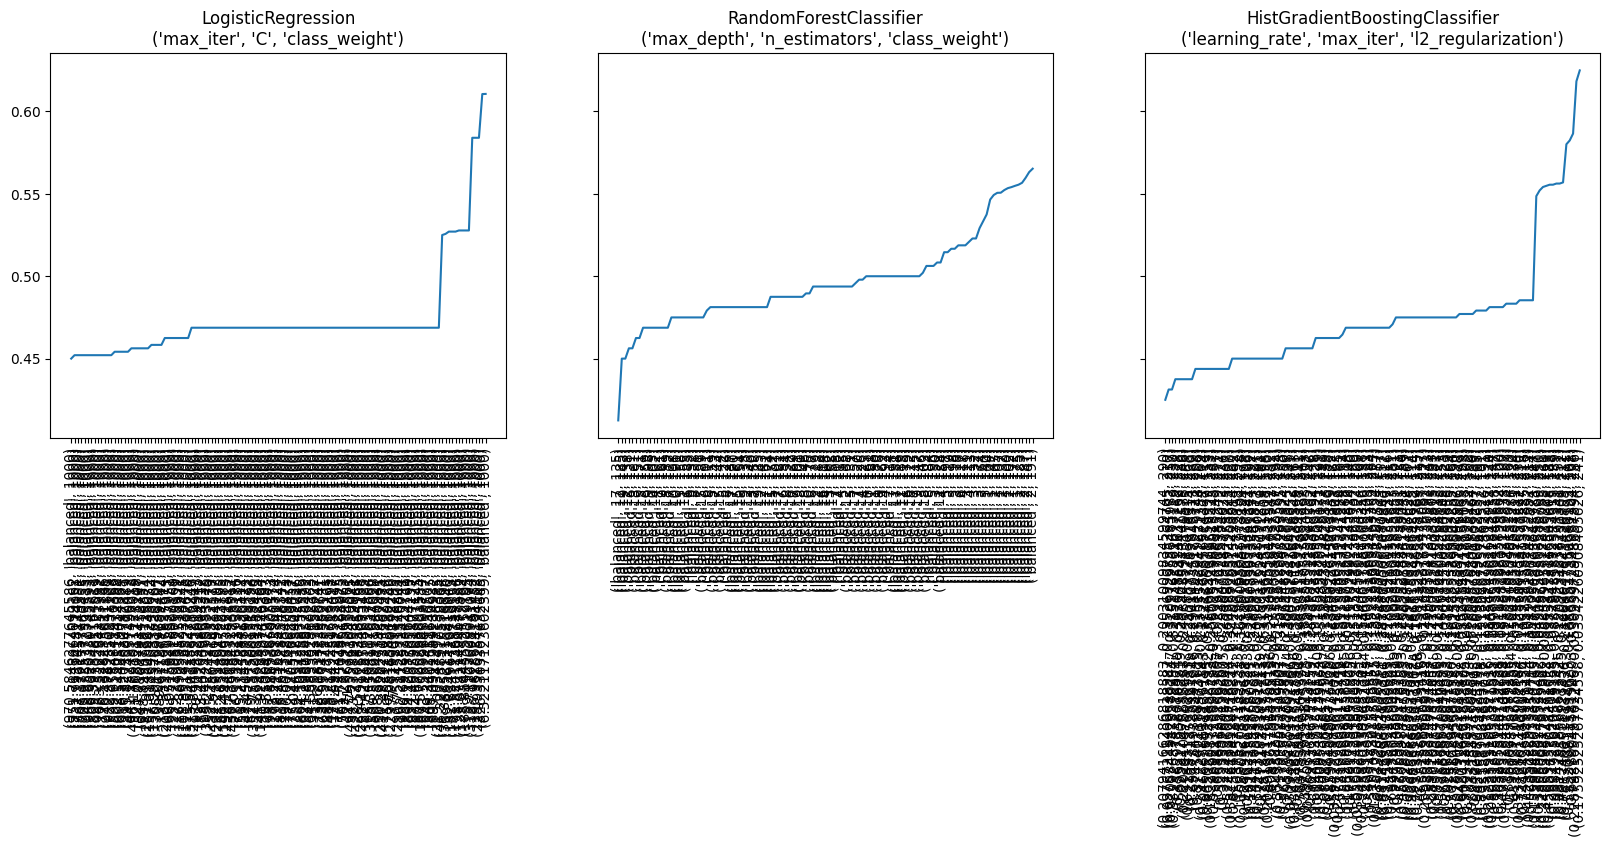

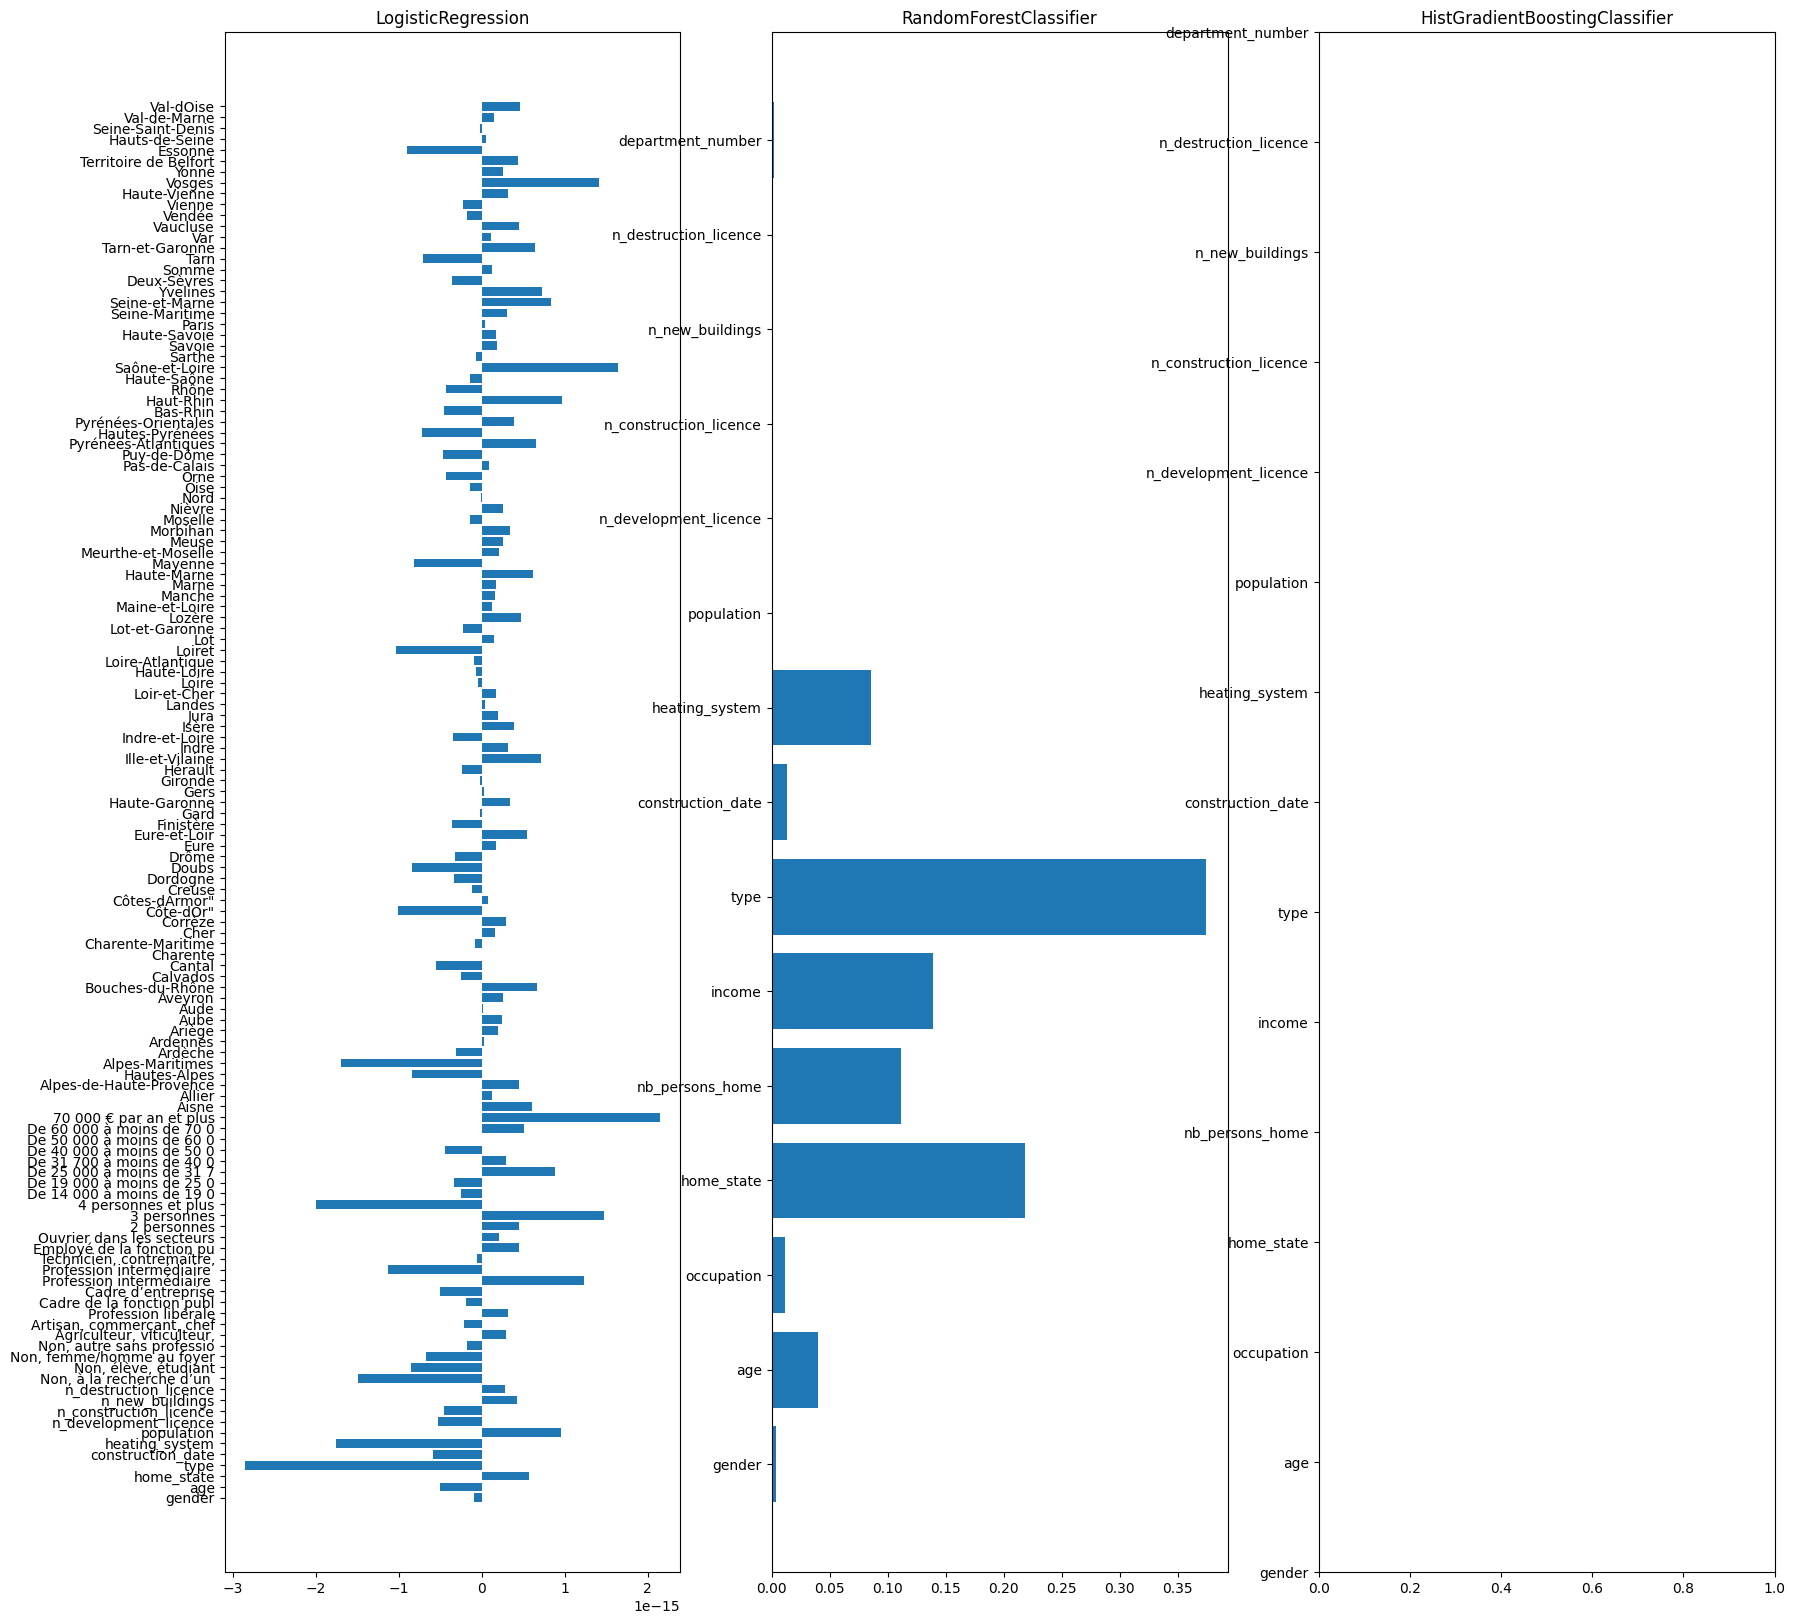

In [8]:
# best model for surface
col_X_hot = [["occupation", "nb_persons_home", "income", "department_number"], [], []]
col_y = ["surface"]
col_X_not_hot = [
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[i] + col_y]
    for i in range(len(col_X_hot))
]

categorical_features = [i for i in range(9)] + [14]

hyperparams_models = [
    {
        "max_iter": [1000],
        "C": uniform(1, 1000),
        "class_weight": ["balanced"],
    },
    {
        "max_depth": randint(1, 50),
        "n_estimators": randint(100, 200),
        "class_weight": ["balanced"],
    },
    {
        "learning_rate": uniform(0.03, 0.3),
        "max_iter": randint(100, 300),
        "l2_regularization": uniform(0, 1),
    },
]
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForestClassifier": RandomForestClassifier,
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier,
}
best_models_surf = prepare_train_show(
    training_surf,
    dictionary,
    categorical_features,
    col_X_hot,
    col_X_not_hot,
    col_y,
    False,
    True,
    hyperparams_models,
    models,
    random_state=42,
    test_size=0.4,
    verbose=0,
    scoring="f1_micro",
)

## heating_production 

[['gender', 'age', 'home_state', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence'], ['gender', 'age', 'occupation', 'home_state', 'nb_persons_home', 'income', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'department_number'], ['gender', 'age', 'occupation', 'home_state', 'nb_persons_home', 'income', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'department_number']]
0.2996913580246914 {'C': 6.522117123602399, 'class_weight': 'balanced', 'max_iter': 1000}
0.44012345679012344 {'class_weight': 'balanced', 'max_depth': 19, 'n_estimators': 171}
0.43603395061728395 {'l2_regularization': 0.1652669390630025, 'learning_rate': 0.03469092202235818, 'max_iter': 108}
not handle

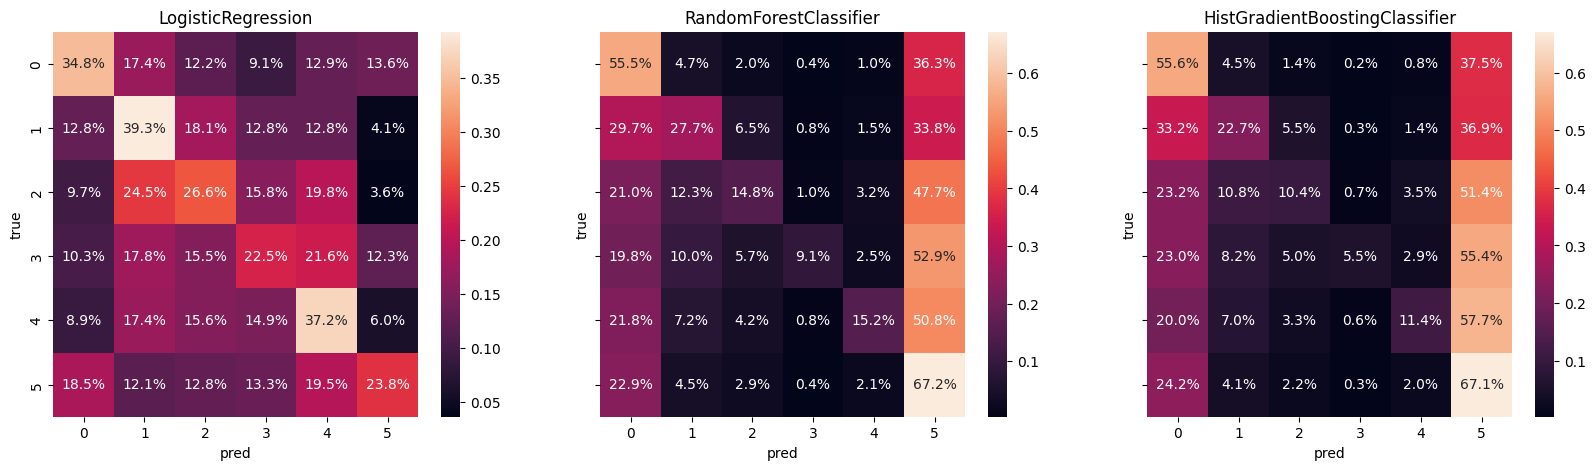

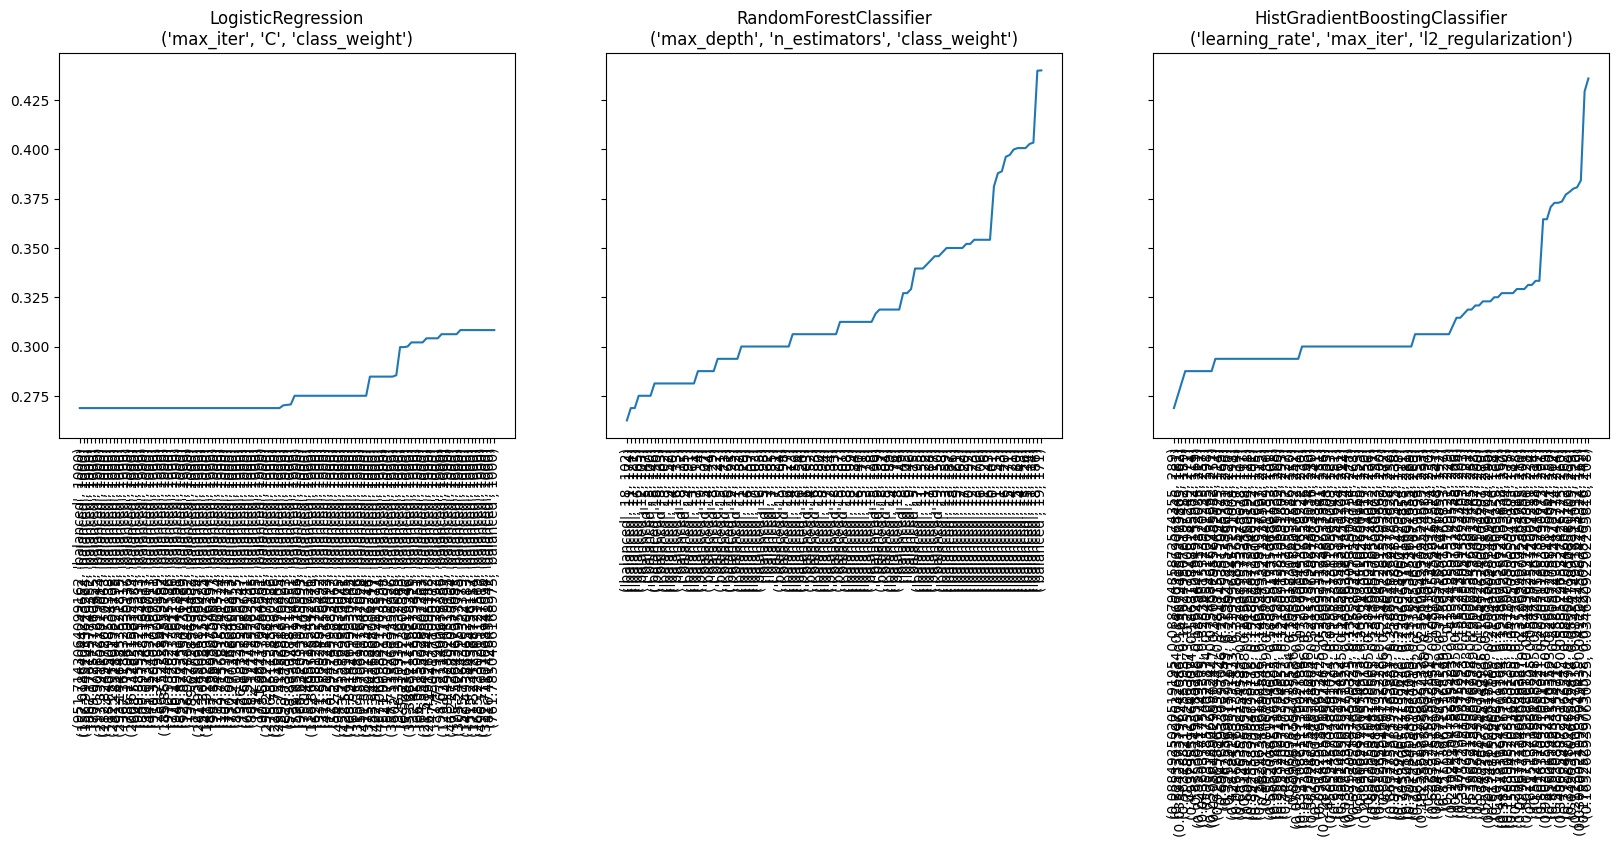

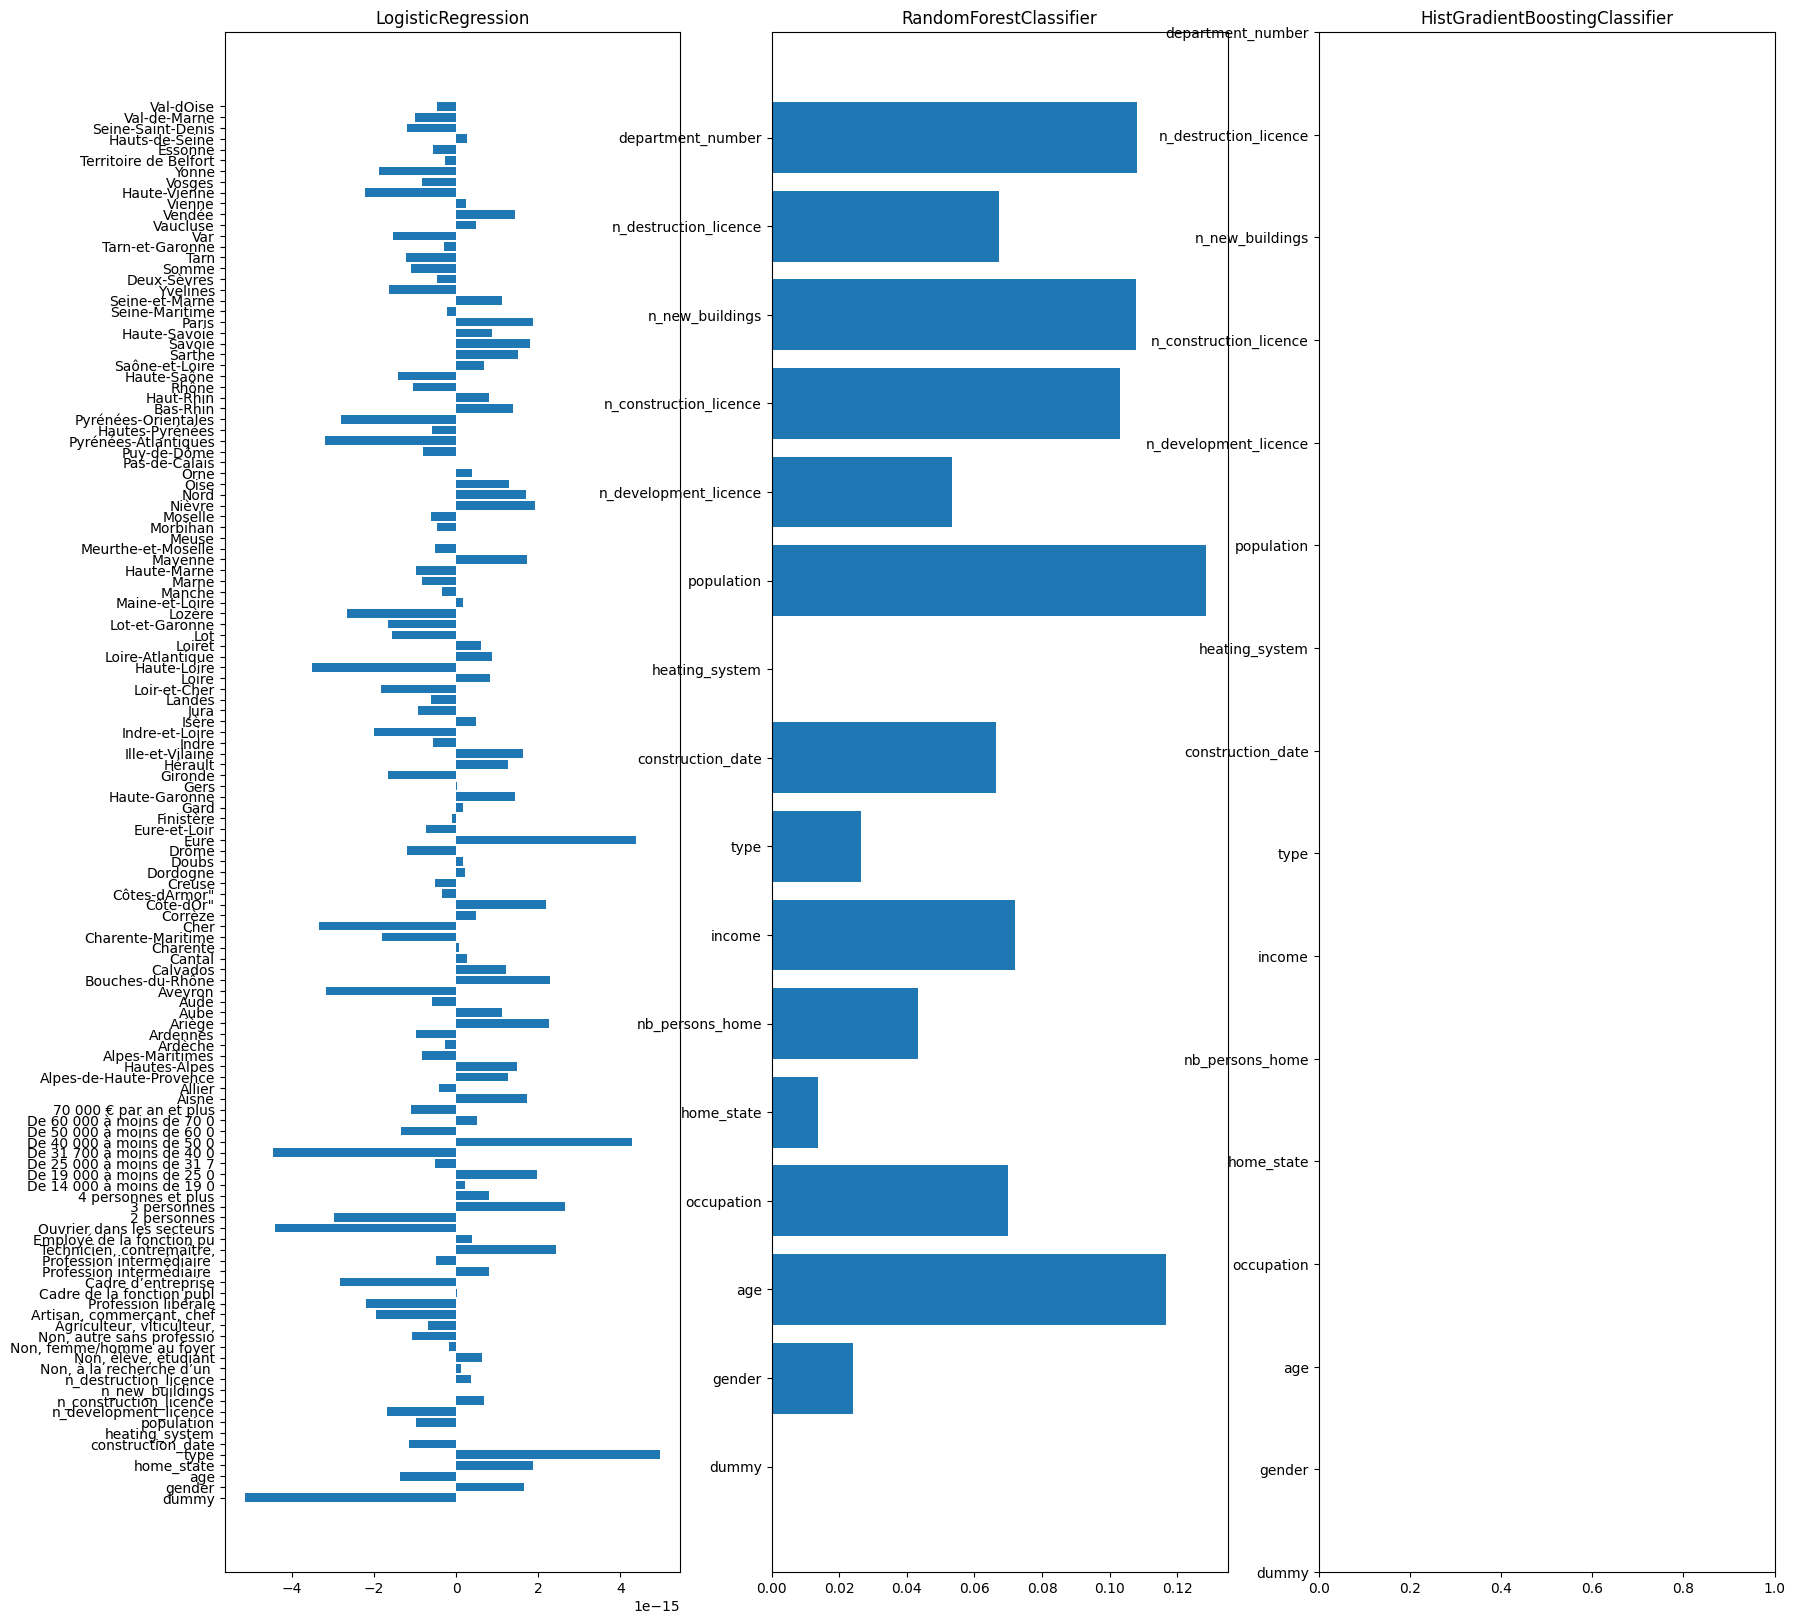

In [ ]:
# best model for heating production
col_X_hot = [["occupation", "nb_persons_home", "income", "department_number"], [], []]
col_y = ["heating_production"]
col_X_not_hot = [
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[i] + col_y]
    for i in range(len(col_X_hot))
]
print(col_X_not_hot)

categorical_features = [i for i in range(9)] + [14]

hyperparams_models = [
    {
        "max_iter": [1000],
        "C": uniform(1, 1000),
        "class_weight": ["balanced"],
    },
    {
        "max_depth": randint(1, 50),
        "n_estimators": randint(100, 200),
        "class_weight": ["balanced"],
    },
    {
        "learning_rate": uniform(0.03, 0.3),
        "max_iter": randint(100, 300),
        "l2_regularization": uniform(0, 1),
    },
]
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForestClassifier": RandomForestClassifier,
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier,
}
best_models_prod = prepare_train_show(
    training_prod,
    dictionary,
    categorical_features,
    col_X_hot,
    col_X_not_hot,
    col_y,
    False,
    True,
    hyperparams_models,
    models,
    random_state=42,
    test_size=0.4,
    scoring="f1_micro",
)